In [1]:
import numpy as np
import torch
import h5py
import re
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim



In [2]:
# hf = h5py.File("Smoke Flow Data.h5", "r")

In [3]:
# print(hf.keys())

In [4]:
# data = np.array(hf['x-50.0']['density'])

In [5]:
# data.shape

In [6]:
# data.shape

In [7]:
# smoke_detectors = np.array([[60.0, 60.0], [30.0,80.0]])

In [8]:
#Trying to find for all source for the given smoke detectors just the time and density is not enough to predict the source 



smoke_detectors = np.array([[60.0, 60.0],[30.0, 80.0]])

# Open the HDF5 file
with h5py.File('Smoke-Flow-Data.h5', 'r') as hf:
    # Initialize lists to store time, x, y, and density values
    all_time_values = []
    all_x_values = []
    all_y_values = []
    all_density_values = []
    all_source_values = []

    
    for smoke_detector_pos in smoke_detectors:
        x, y = smoke_detector_pos
        # Loop through groups in the file
        for source_group in hf.keys():
            group = hf[source_group]
            density_dataset = group['density']
            source_value = float(source_group.split('-')[-1])
    
            # Extract density value at time t, position (x, y)
            density_value = density_dataset[:, int(x), int(y), 0]  # assuming vector component 0

            # Append the source, time, x, y, and density values to the lists
            all_source_values.append(source_value)  
            # all_time_values.append(t)
            # all_x_values.append(x)
            # all_y_values.append(y)
            all_density_values.append(density_value)
            # print(source_value,t,density_value)


In [9]:
# # Convert lists to PyTorch tensors
source_tensor = torch.tensor(all_source_values, dtype=torch.float32)
density_tensor = torch.tensor(all_density_values, dtype=torch.float32)


/var/folders/8q/q92h73g16_ldnwcqz3s616f80000gn/T/ipykernel_9582/4074534891.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  density_tensor = torch.tensor(all_density_values, dtype=torch.float32)


In [10]:
# print(time_tensor.shape)
print(density_tensor.shape)
print(source_tensor.shape)

torch.Size([18, 501])
torch.Size([18])


In [11]:
density_tensor= density_tensor.view(9,2,-1)
print(density_tensor.shape)

torch.Size([9, 2, 501])


In [12]:
# for i in range(density_tensor.size(0)):
#     print(f"Values in the first dimension (batch {i}): {density_tensor[i]}")
#     print("length",len(density_tensor[i]))

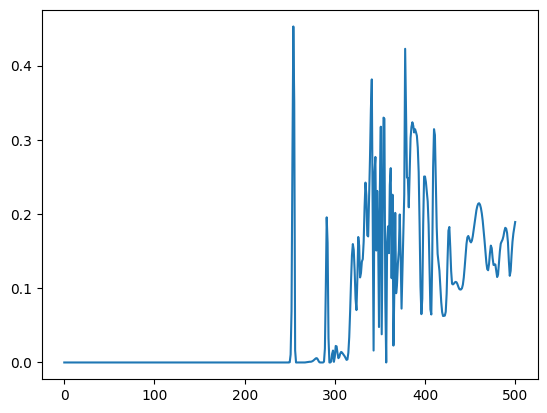

In [13]:
plt.plot(density_tensor[4,0,:])

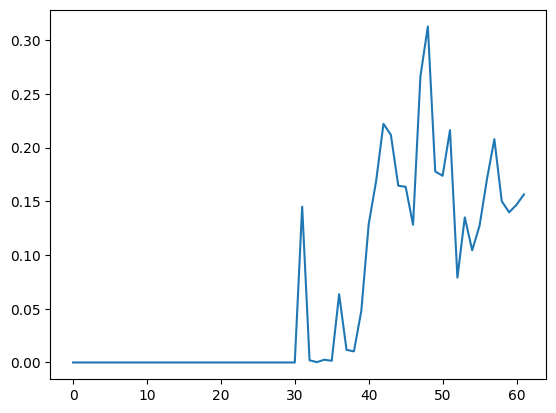

In [14]:
# import torch.nn as nn
my_test_layer = nn.AvgPool1d(8)
plt.plot(my_test_layer(density_tensor)[4,0,:])

In [15]:
# conv1d_layer = torch.nn.Conv1d(in_channels=2, out_channels =2 , kernel_size=9)
source_tensor = torch.randn((9, 1))  # Assuming 1D output
# print(source_tensor.shape)
# print(len(density_tensor))

In [16]:
# Assuming you have separate training and testing datasets
num_samples = len(density_tensor)
split_ratio = 0.8
split_index = int(split_ratio * num_samples)

In [17]:
train_density = density_tensor[:split_index]
test_density = density_tensor[split_index:]
train_source = source_tensor[:split_index]
test_source = source_tensor[split_index:]


In [18]:
batch_size = 8

# Create DataLoader for training set
train_dataset = TensorDataset(train_density, train_source)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing set
test_dataset = TensorDataset(test_density, test_source)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [19]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=1)

        self.relu1 = nn.ReLU()
    
        self.avgpool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=1)
    
        self.avgpool2 = nn.AvgPool1d(4)

        self.conv3 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, stride=2, padding=1)
       
        self.avgpool3 = nn.AvgPool1d(2)

        self.relu2 = nn.ReLU()

        self.conv4 = nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3, stride=1, padding=1)

        self.relu3 = nn.ReLU()

        # Adjust the linear layer input size based on the number of output channels from the last convolutional layer
        # self.fc = nn.Linear(8, 16)
        self.flatten = nn.Flatten()
        # self.linear_layer = nn.Linear(8, 16)

    def forward(self, x):
    

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.avgpool1(x)
        
        x = self.conv2(x)
        # x = self.relu2(x)
        x = self.avgpool2(x)

        x = self.conv3(x)
        x = self.avgpool3(x)
        x = self.relu2(x)

        x = self.conv4(x)
        x = self.relu3(x)
      

        # print("Size before flattening:", x.size())  # Add this line to check the size

        x = self.flatten(x)

        # print("Size before reshaping:", x.size())

        return x


In [20]:
# def lr_lambda(epoch):
#     # LR to be 0.1 * (1/1+0.01*epoch)
#     base_lr = 0.1
#     factor = 0.001
#     return base_lr/(1+factor*epoch)

In [21]:
# Create an instance of the model
model = SimpleCNN()
## List for loss
train_losses = []
test_losses = []

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
# scheduler = optim.lr_scheduler.LambdaLR(optimizer,lr_lambda)  # Adjust step_size and gamma as needed


# Training loop
epochs = 2000
for epoch in range(epochs):
    model.train()
    for density_batch, source_batch in train_loader:
        # # Forward pass
        # print(density_batch.shape)
        outputs = model(density_batch)

        # Compute loss
        loss = criterion(outputs, source_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate scheduler step
    # scheduler.step()
    
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item()}')

# Testing loop
    model.eval()
with torch.no_grad():
    for density_batch, source_batch in test_loader:
        test_outputs = model(density_batch)
        test_loss = criterion(test_outputs, source_batch)
        

# After training and testing, you can use the model to make predictions
predicted_sources = model(density_tensor)

/Users/kee/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [0/2000], Loss: 0.3589603304862976
Epoch [10/2000], Loss: 0.34520938992500305
Epoch [20/2000], Loss: 0.331435889005661
Epoch [30/2000], Loss: 0.31775203347206116
Epoch [40/2000], Loss: 0.3044640123844147
Epoch [50/2000], Loss: 0.29241886734962463
Epoch [60/2000], Loss: 0.28288623690605164
Epoch [70/2000], Loss: 0.27801916003227234
Epoch [80/2000], Loss: 0.2764889597892761
Epoch [90/2000], Loss: 0.2756100296974182
Epoch [100/2000], Loss: 0.2748318016529083
Epoch [110/2000], Loss: 0.27407747507095337
Epoch [120/2000], Loss: 0.2733253836631775
Epoch [130/2000], Loss: 0.2725658416748047
Epoch [140/2000], Loss: 0.27179571986198425
Epoch [150/2000], Loss: 0.27101510763168335
Epoch [160/2000], Loss: 0.27023544907569885
Epoch [170/2000], Loss: 0.26974114775657654
Epoch [180/2000], Loss: 0.2693716585636139
Epoch [190/2000], Loss: 0.26903775334358215
Epoch [200/2000], Loss: 0.26873552799224854
Epoch [210/2000], Loss: 0.2684459090232849
Epoch [220/2000], Loss: 0.2681635022163391
Epoch [230/

/Users/kee/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
